In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
## This method is for determening outliers
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_ouliers = Q3 + 1.5 * IQR
    lower_outliers = Q1 - 1.5 * IQR
    outliers = series[(series < lower_outliers) | (series > upper_ouliers)]
    return len(outliers)

## Content of the tables
### Chemicals table - all of the concentration of the specific chemical, code for the sensor, amount of water(all the data is from 2023)
### Merged_oxygen table - the code of the sensor(it is either 01/07, but it is the same sensor), amount of oxygen, start time, end time(data from 2021)


In [3]:
ammonium = pd.read_parquet('data/Chemical measurements influent 2023_2024/ammonium_2024.parquet')
ammonium['datumBeginMeting'] = pd.to_datetime(ammonium['datumBeginMeting'])
ammonium = ammonium.rename(columns={"hstWaarde": "hstWaarde_ammonium_2023", "historianTagnummer": "historianTagnummer_ammonium"}).reset_index(drop=True)
ammonium['hstWaarde_ammonium_2023'] = ammonium['hstWaarde_ammonium_2023'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  43282


{'whiskers': [<matplotlib.lines.Line2D at 0x7f276030eb10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f276030f800>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f276030dca0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f276030fe00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f273a6d4140>],
 'means': []}

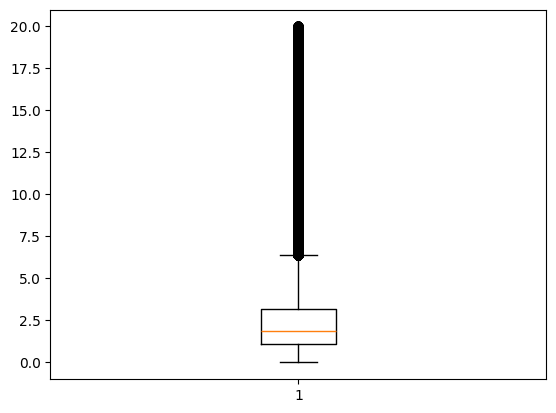

In [4]:
outliers_count = count_outliers_iqr(ammonium['hstWaarde_ammonium_2023'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(ammonium['hstWaarde_ammonium_2023'])

In [5]:
nitrate = pd.read_parquet('data/Chemical measurements influent 2023_2024/nitrate_2024.parquet')
nitrate['datumBeginMeting'] = pd.to_datetime(nitrate['datumBeginMeting'])
nitrate = nitrate.rename(columns={"hstWaarde": "hstWaarde_nitrate", "historianTagnummer": "historianTagnummer_nitrate"}).reset_index(drop=True)
nitrate['hstWaarde_nitrate'] = nitrate['hstWaarde_nitrate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f27397e9a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f27397ea060>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f27397e9730>],
 'medians': [<matplotlib.lines.Line2D at 0x7f27397ea540>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f27397ea810>],
 'means': []}

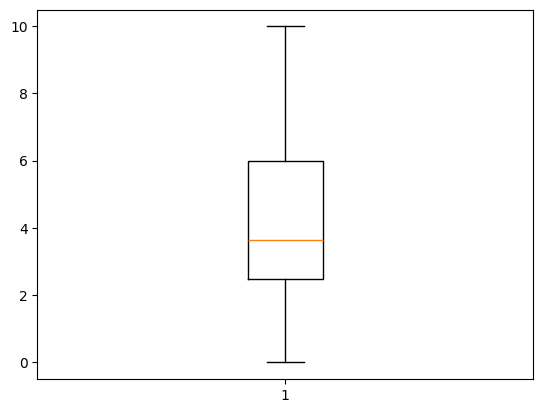

In [6]:
outliers_count = count_outliers_iqr(nitrate['hstWaarde_nitrate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(nitrate['hstWaarde_nitrate'])

In [7]:
phosphate = pd.read_parquet('data/Chemical measurements influent 2023_2024/phosphate_2024.parquet')
phosphate['datumBeginMeting'] = pd.to_datetime(phosphate['datumBeginMeting'])
phosphate = phosphate.rename(columns={"hstWaarde": "hstWaarde_phosphate", "historianTagnummer": "historianTagnummer_phosphate"}).reset_index(drop=True)
phosphate['hstWaarde_phosphate'] = phosphate['hstWaarde_phosphate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  21886


{'whiskers': [<matplotlib.lines.Line2D at 0x7f275f5bb890>,
 'caps': [<matplotlib.lines.Line2D at 0x7f27397c0c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f275f5bb650>],
 'medians': [<matplotlib.lines.Line2D at 0x7f275f5e4170>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f275f5e4440>],
 'means': []}

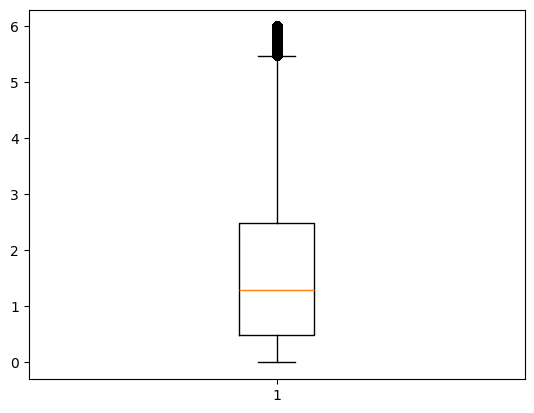

In [8]:
outliers_count = count_outliers_iqr(phosphate['hstWaarde_phosphate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(phosphate['hstWaarde_phosphate'])

In [9]:
merged = pd.merge(ammonium, nitrate, on="datumBeginMeting")
chemicals = pd.merge(merged, phosphate, on="datumBeginMeting")
chemicals_hourly = pd.DataFrame({
    'Hour': chemicals['datumBeginMeting'].dt.floor('h'),  # Hour column for grouping
    'ammonium': chemicals['hstWaarde_ammonium_2023'],
    'nitrate': chemicals['hstWaarde_nitrate'],
    'phosphate': chemicals['hstWaarde_phosphate']
})

hourly_means = chemicals_hourly.groupby('Hour')[['ammonium', 'nitrate', 'phosphate']].mean().reset_index()

hourly_means

,Hour,ammonium,nitrate,phosphate
0,2023-01-01 00:00:00,1.037983,4.424633,0.003450
1,2023-01-01 01:00:00,1.938650,3.062367,0.380733
2,2023-01-01 02:00:00,1.885600,3.344783,0.169217
3,2023-01-01 03:00:00,0.933100,2.867483,0.161217
4,2023-01-01 04:00:00,0.772933,2.491967,0.112783
...,...,...,...,...
8751,2023-12-31 19:00:00,2.728717,9.777850,0.503533
8752,2023-12-31 20:00:00,3.159783,9.974633,0.351133
8753,2023-12-31 21:00:00,1.736383,9.390367,0.135667
8754,2023-12-31 22:00:00,1.838267,9.643633,0.152550


Nitrate IQR Visualization

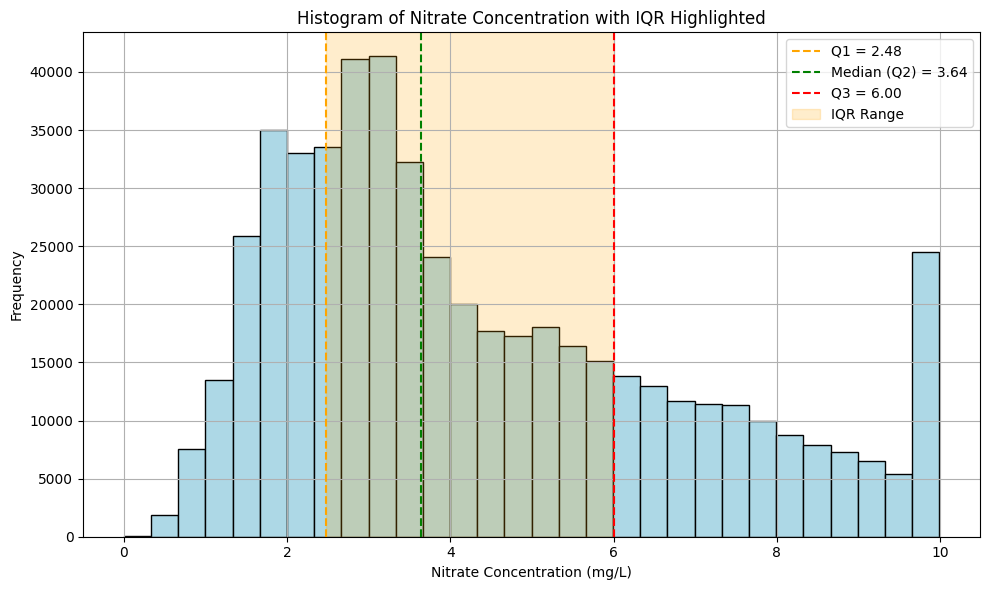

In [10]:
q1 = merged['hstWaarde_nitrate'].quantile(0.25)
q2 = merged['hstWaarde_nitrate'].quantile(0.50)  
q3 = merged['hstWaarde_nitrate'].quantile(0.75)
 
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(merged['hstWaarde_nitrate'], bins=30, color='lightblue', edgecolor='black')
 
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1 = {q1:.2f}')
plt.axvline(q2, color='green', linestyle='--', label=f'Median (Q2) = {q2:.2f}')
plt.axvline(q3, color='red', linestyle='--', label=f'Q3 = {q3:.2f}')
 
plt.axvspan(q1, q3, color='orange', alpha=0.2, label='IQR Range')
 
plt.title('Histogram of Nitrate Concentration with IQR Highlighted')
plt.xlabel('Nitrate Concentration (mg/L)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Seasons visualization

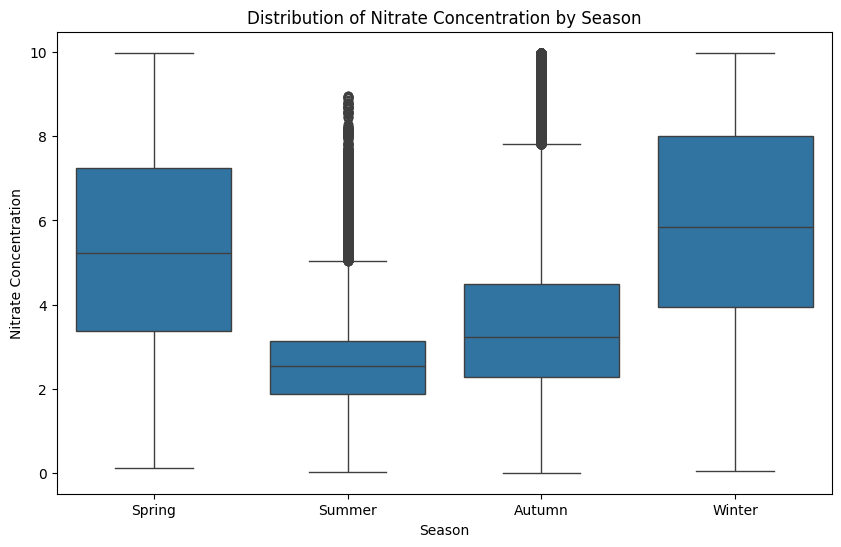

In [11]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
 
merged['Season'] = merged['datumBeginMeting'].apply(get_season)
 
plt.figure(figsize=(10,6))
sns.boxplot(x='Season', y='hstWaarde_nitrate', data=merged, order=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title('Distribution of Nitrate Concentration by Season')
plt.ylabel('Nitrate Concentration')
plt.xlabel('Season')
plt.show()

In [12]:
weather = pd.read_csv('weather.csv')
weather = weather.rename(columns={'Timestamp': 'Hour'})
weather['Hour'] = pd.to_datetime(weather['Hour'])
weather

,Hour,Station,WindDirection,WindSpeedMean_10min,WindSpeedLast10Min,WindGustMax,Temperature,MinTemp_10cm_6hr,DewPointTemp,SunshineDuration,...,Visibility,CloudCover,RelativeHumidity,WeatherCode,WeatherCodeIndicator,Fog,Rain,Snow,Thunder,IceFormation
0,2023-01-01 00:00:00,275,220,100,90,150,153,,76,0,...,82,8,59,23,7,0,1,0,0,0
1,2023-01-01 01:00:00,275,220,100,90,170,146,,77,0,...,83,8,63,81,7,0,1,0,0,0
2,2023-01-01 02:00:00,275,210,90,90,140,150,,67,0,...,83,8,57,23,7,0,1,0,0,0
3,2023-01-01 03:00:00,275,220,90,90,150,147,,64,0,...,83,8,57,,5,0,0,0,0,0
4,2023-01-01 04:00:00,275,240,80,70,180,141,,72,0,...,83,8,63,23,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,275,200,60,70,110,81,,46,0,...,62,8,78,51,7,0,1,0,0,0
8756,2023-12-31 20:00:00,275,200,80,70,130,82,,47,0,...,72,8,78,81,7,0,1,0,0,0
8757,2023-12-31 21:00:00,275,200,80,90,140,85,,43,0,...,75,8,74,81,7,0,1,0,0,0
8758,2023-12-31 22:00:00,275,200,80,80,130,83,,42,0,...,75,7,75,23,7,0,1,0,0,0


In [13]:
combined = pd.merge(hourly_means, weather, on='Hour', how='inner')
combined
combined.to_csv('combined.csv', index=False)

Pearson Correlation Heatmap

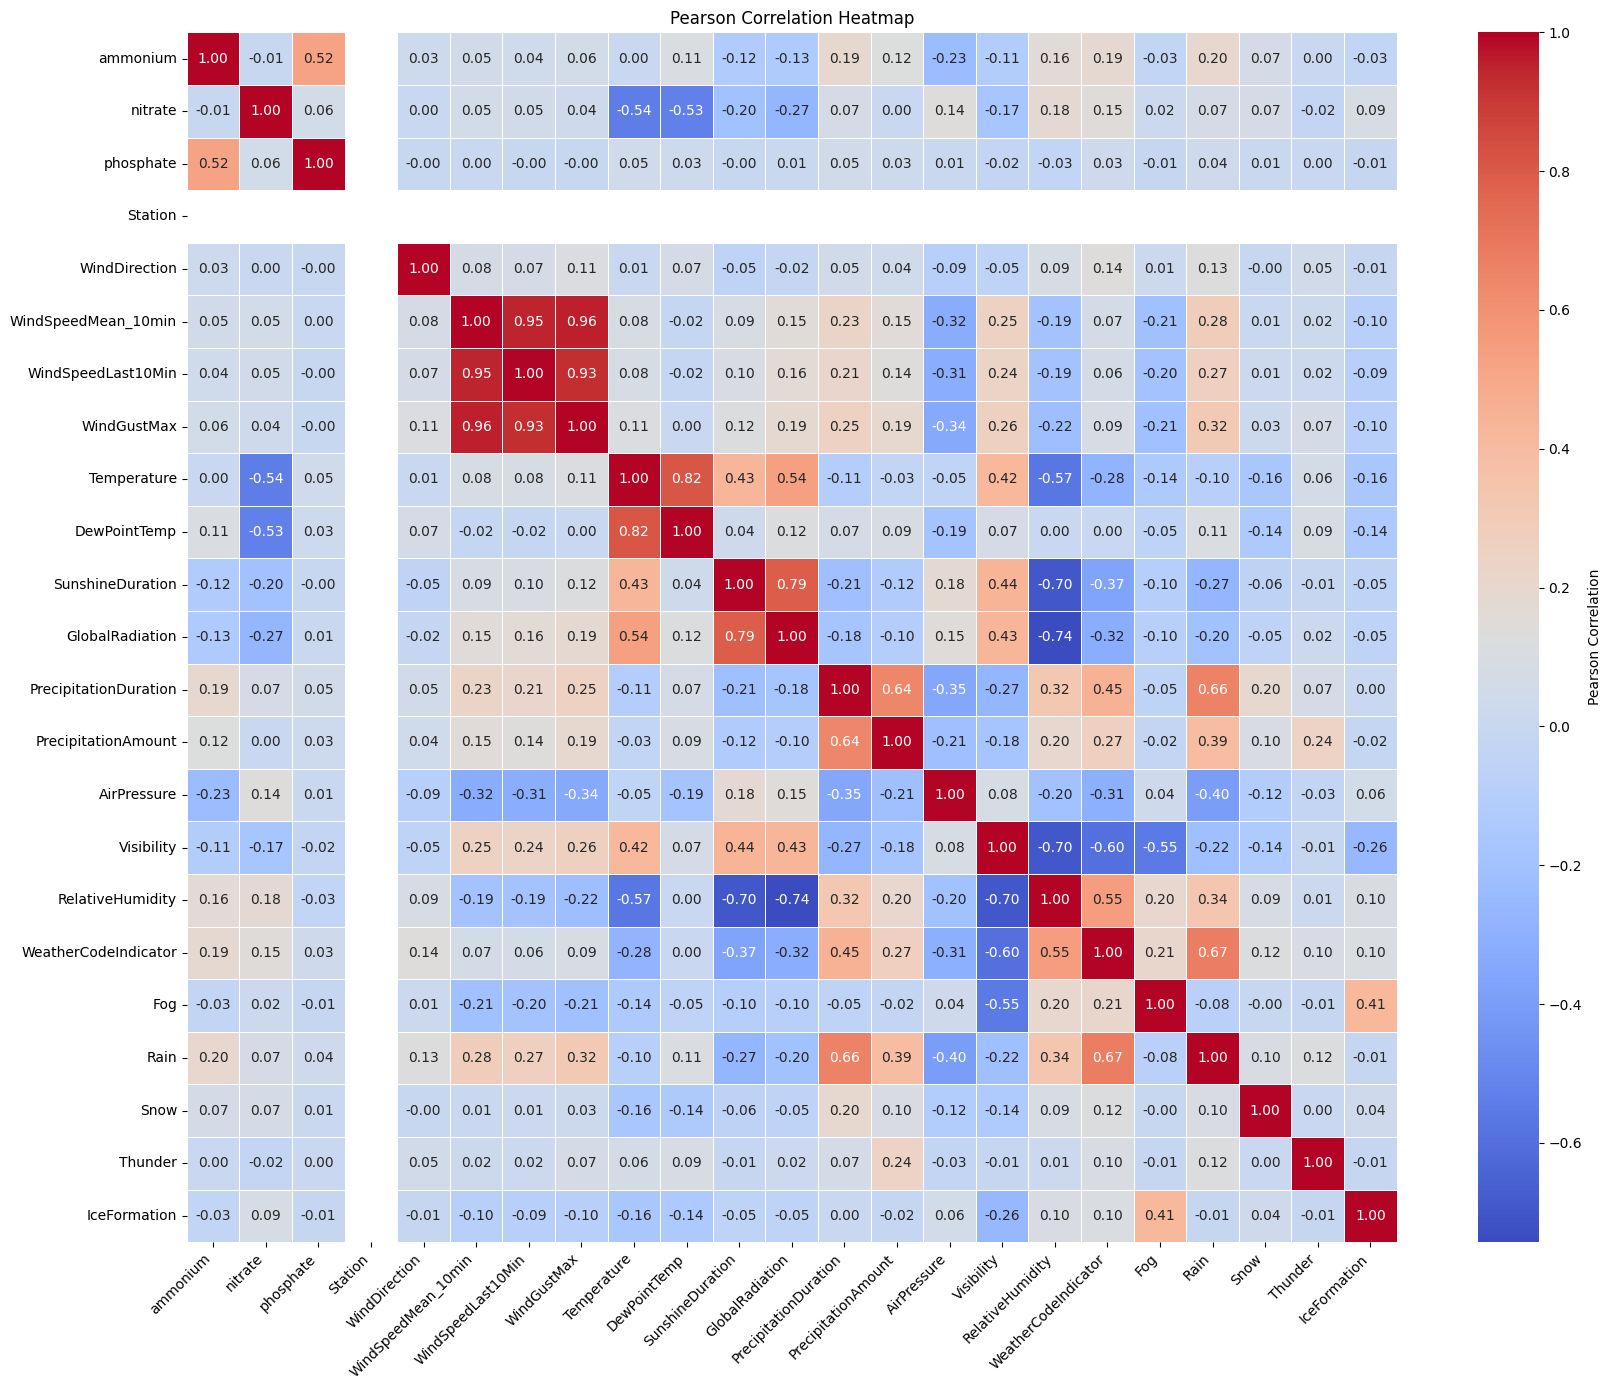

In [14]:
numeric_data = combined.select_dtypes(include='number')
pearson_corr = numeric_data.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    pearson_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation"}
)
plt.title("Pearson Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Spearman Correlation Heatmap

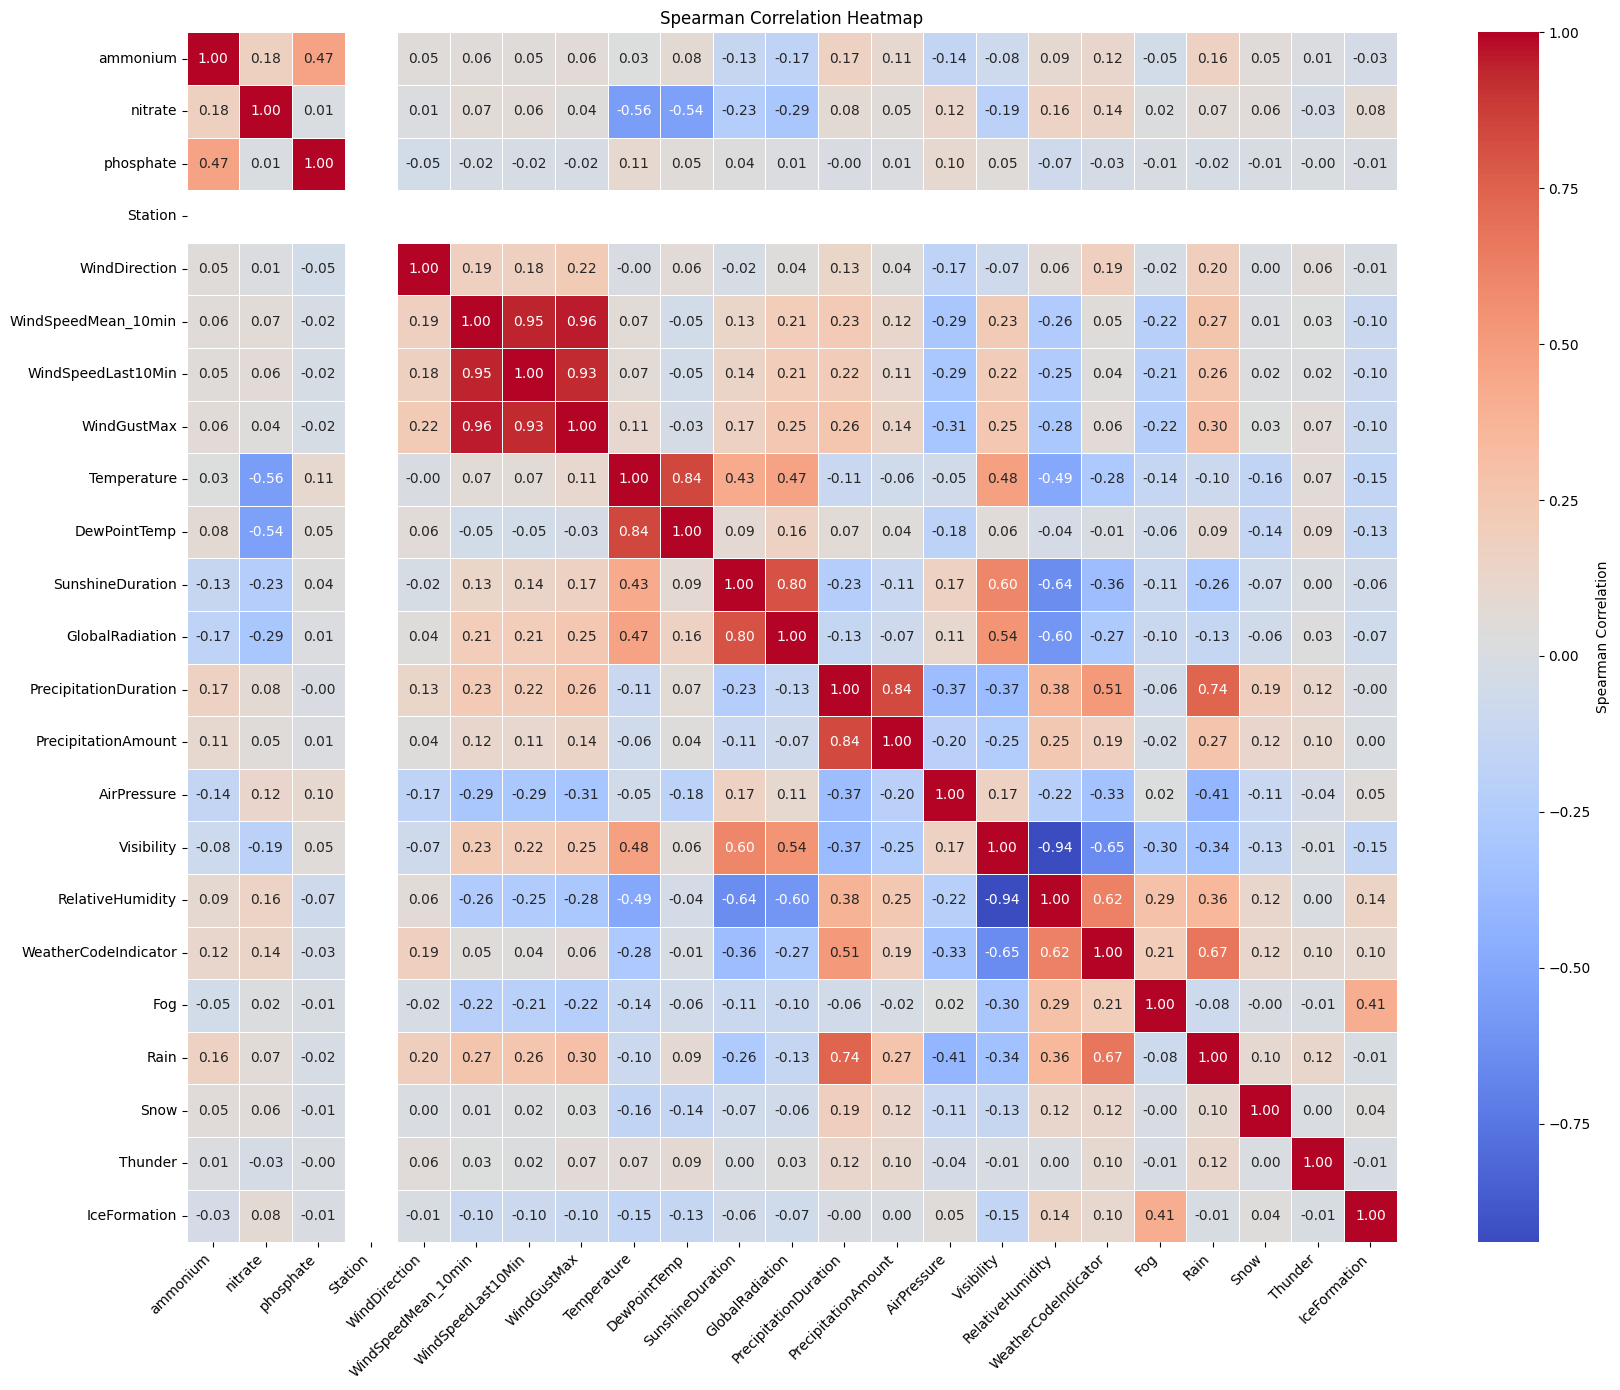

In [15]:
numeric_data = combined.select_dtypes(include='number')
spearman_corr = numeric_data.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    spearman_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Spearman Correlation"}
)
plt.title("Spearman Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_145874/4081920338.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette="viridis")


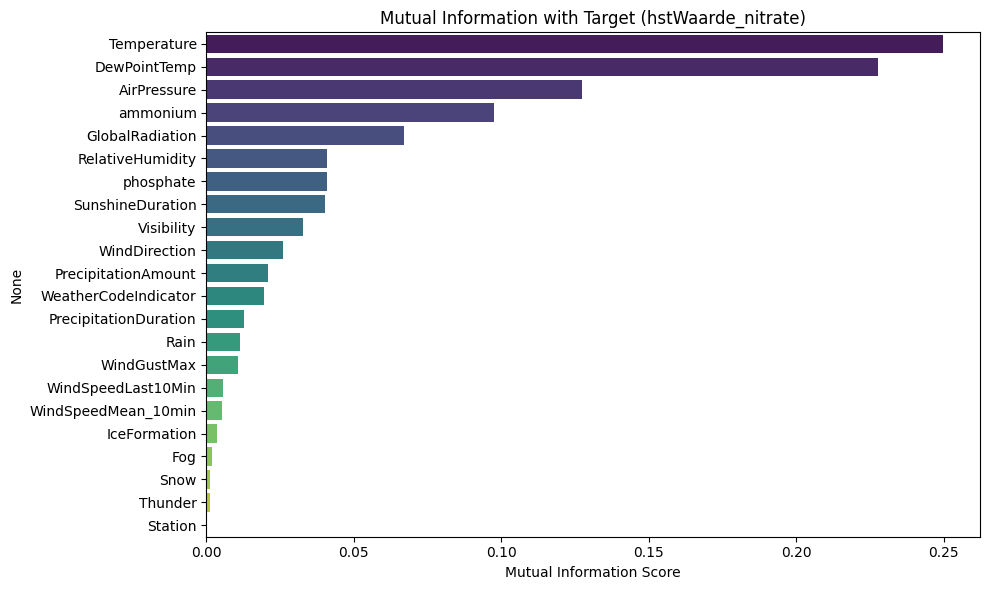

In [16]:
from sklearn.feature_selection import mutual_info_regression

# Example: measure mutual information with respect to a target
target = 'nitrate'
X = combined.drop(columns=[target])
X = X.select_dtypes(include=['int64', 'float64']) 
y = combined[target]

mi = mutual_info_regression(X, y, discrete_features=False)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores.values, y=mi_scores.index, palette="viridis")
plt.title("Mutual Information with Target (hstWaarde_nitrate)")
plt.xlabel("Mutual Information Score")
plt.tight_layout()
plt.show()

In [17]:
features = ['ammonium', 'phosphate', 'WindDirection', 'WindSpeedMean_10min',
    'Temperature', 'DewPointTemp', 'RelativeHumidity', 'AirPressure',
    'PrecipitationAmount']
X = combined[features]
y = combined['nitrate'].values


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
# Compute the mean of the training target
mean_y_train = np.mean(y_train)

# Predict the mean for all test samples
y_baseline_pred = np.full_like(y_test, fill_value=mean_y_train)

# Evaluate the baseline model
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

print("Manual Mean Baseline - Test MSE :", baseline_mse)
print("Manual Mean Baseline - Test RMSE:", baseline_rmse)


Manual Mean Baseline - Test MSE : 5.994596491035666
Manual Mean Baseline - Test RMSE: 2.4483865076894347


In [74]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [103]:
model = Pipeline([
    ("imputing", SimpleImputer(strategy="median")),
    ("scaling", StandardScaler()),
    ("feature_select", SelectKBest(score_func=f_regression, k='all')), 
    ("modeling", RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

In [104]:
cv_score = cross_val_score(estimator=model, X=X_train, y=y_train,cv=kf)

In [105]:
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

In [106]:
y_train_pred = cross_val_predict(model, X_train, y_train, cv=kf)

In [107]:
print("Train CV MSE :", mean_squared_error(y_train, y_train_pred))
print("Train CV RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

print("Test MSE     :", mean_squared_error(y_test, y_test_pred))
print("Test RMSE    :", np.sqrt(mean_squared_error(y_test, y_test_pred)))

Train CV MSE : 2.192139607889969
Train CV RMSE: 1.4805875887261681
Test MSE     : 2.1151877596838666
Test RMSE    : 1.454368508901326
